In [105]:
import ipyvolume as ipv
import tyssue
import json
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import random
import sys
import tyssue.io.hdf5 as hdf5
from IPython.display import Image
from scipy import optimize
from tyssue.draw import sheet_view
from tyssue.geometry.planar_geometry import PlanarGeometry as geom

##### Own functions
import src.vertexModel as vertexModel
import src.inputMechanicalParameters as inputMechanicalParameters
import src.auxFunctions as auxFunctions
from tyssue.topology import add_vert
import src.cellDivision as cellDivision


from tyssue.topology.base_topology import add_vert, close_face, collapse_edge, remove_face
from tyssue.topology.base_topology import split_vert as base_split_vert

Topology changed!


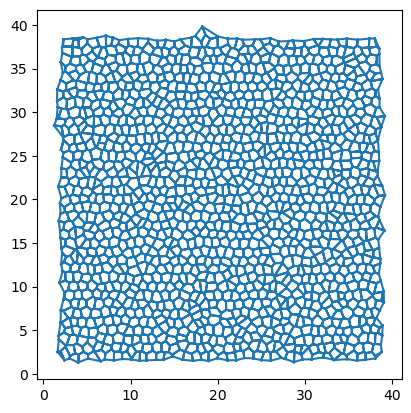

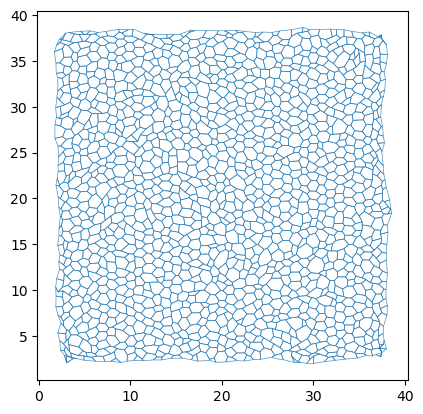

In [106]:
#### Initialize Model
[cellmap_init, geom, energyContributions_model] = vertexModel.initialize()

## Update mechanical parameters
cellmap_init = inputMechanicalParameters.update(cellmap_init)

## Initial stage
energyContributions_model.compute_energy(cellmap_init)

## RUN
[cellmap_H, geom, model_H, history_H] = vertexModel.solveEuler(cellmap_init, geom, energyContributions_model, endTime = 100)


fig, ax = sheet_view(cellmap_H, ['y', 'x'], edge={"color":1, 'colormap': 'Greys'})
#auxFunctions.create_frames(history_H, './results', edge={'color':'black'})
#auxFunctions.exportToMesh(history_H, './results')

import warnings
warnings.filterwarnings("ignore")

In [107]:
cellmap_H.edge_df

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,uy,rx,ry,sub_area,is_active,length_elasticity,prefered_length,uz,length_elasticity_ECM,length_elasticity_FRC
edge,,,,,,,,,,,,,,,,,,,,,
0,30,0.646859,0.976378,418,1,0.055157,0.974819,10.825016,12.104506,10.880173,...,0.998403,0.616740,-0.827626,0.323430,1,782.888267,0.972614,0.57735,280.874431,502.013836
1,1,0.447772,0.976378,382,30,-0.055157,-0.974819,10.880173,13.079326,10.825016,...,-0.998403,-0.401995,1.013467,0.223886,1,782.888267,0.638054,0.57735,280.874431,502.013836
2,3,0.408981,1.014311,381,1,-0.991671,0.213109,10.825016,12.104506,9.833344,...,0.210102,0.434636,0.319013,0.204491,1,694.450370,0.958994,0.57735,201.678244,492.772125
3,1,0.689300,1.014311,418,3,0.991671,-0.213109,9.833344,12.317616,10.825016,...,-0.210102,-0.374932,-0.614517,0.344650,1,694.450370,0.725075,0.57735,201.678244,492.772125
4,3,0.387897,0.547628,418,2,0.409117,-0.364033,9.424227,12.681649,9.833344,...,-0.664745,-0.784049,-0.250484,0.193948,1,774.597641,0.873878,0.57735,258.528549,516.069092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8112,2752,0.377724,0.508315,291,857,-0.280422,0.423967,32.890372,9.293560,32.609950,...,0.834064,0.694456,0.297043,0.188862,1,767.859066,0.524644,0.57735,223.186121,544.672945
8113,1154,0.365820,0.612255,887,2753,-0.284152,-0.542323,34.352750,25.736460,34.068599,...,-0.885780,-0.428553,0.469489,0.182910,1,763.815801,0.209208,0.57735,299.859179,463.956622
8114,2753,0.382393,0.612255,922,1154,0.284152,0.542323,34.068599,25.194136,34.352750,...,0.885780,0.354988,-0.668216,0.191196,1,763.009947,0.316294,0.57735,238.940744,524.069203


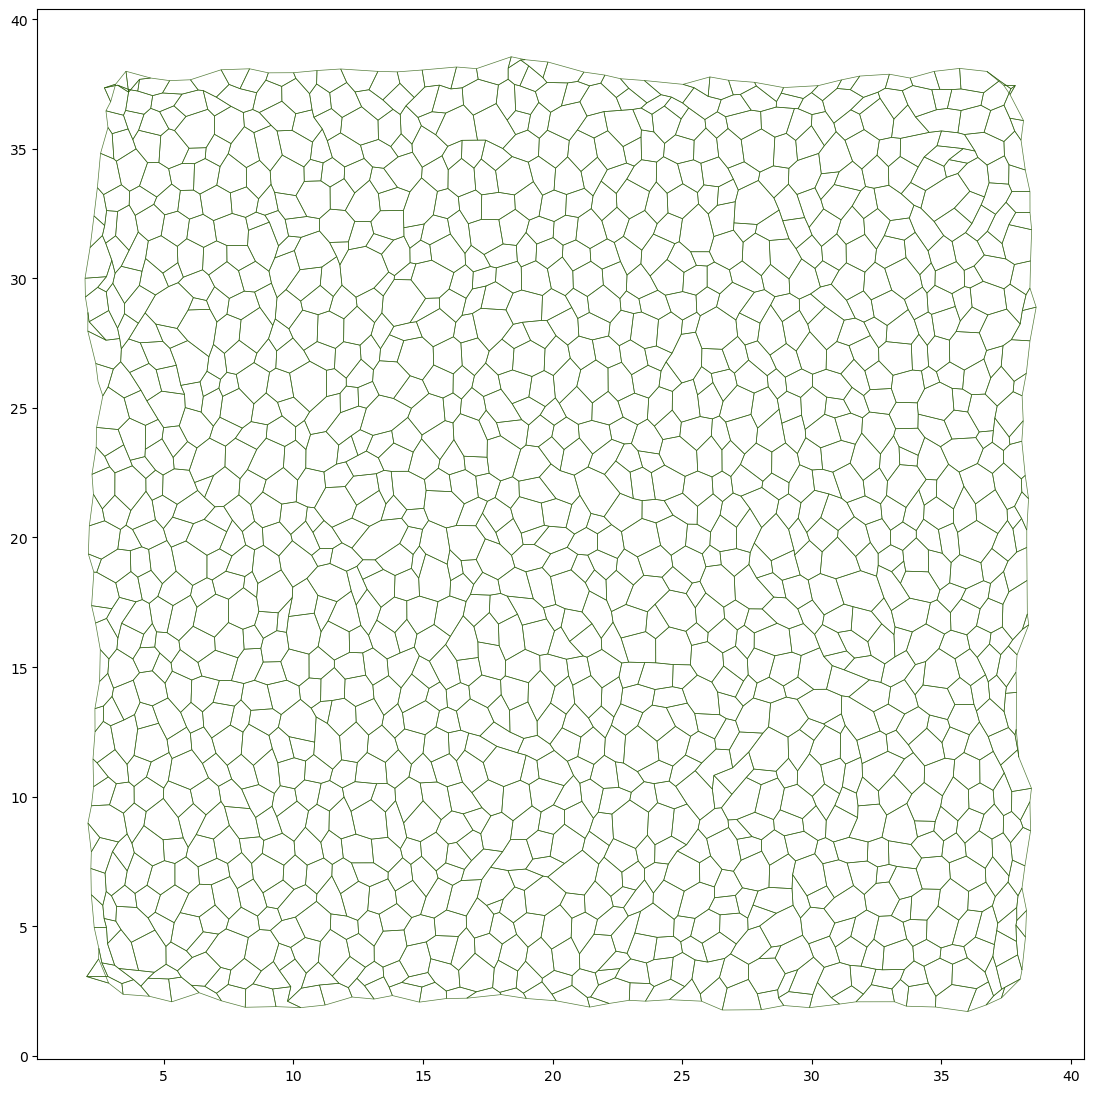

In [108]:
fig, ax = sheet_view(cellmap_H)
fig.set_size_inches((15, 15))
plt.show() 

In [109]:
### match length_elasticity of opposite edges 

for edge in range(len(cellmap_H.edge_df)):
    
    ### find the opposite edge of each edge in edges_list_without_opposites
    
    opposite_edge_indices = cellmap_H.edge_df[
        (cellmap_H.edge_df["srce"] == cellmap_H.edge_df.loc[edge, "trgt"]) &
        (cellmap_H.edge_df["trgt"] == cellmap_H.edge_df.loc[edge, "srce"])
    ].index
    


    if len(opposite_edge_indices):
            # Update the values for the opposite edges
            cellmap_H.edge_df['length_elasticity_ECM'][opposite_edge_indices] = cellmap_H.edge_df['length_elasticity_ECM'][edge] 
            cellmap_H.edge_df['length_elasticity_FRC'][opposite_edge_indices] = cellmap_H.edge_df['length_elasticity_FRC'][edge] 
            cellmap_H.edge_df['length_elasticity'][opposite_edge_indices] = cellmap_H.edge_df['length_elasticity'][edge]

In [110]:
### match prefered_length of opposite edges 


for edge in range(len(cellmap_H.edge_df)):
    
    ### find the opposite edge of each edge in edges_list_without_opposites
    
    opposite_edge_indices = cellmap_H.edge_df[
        (cellmap_H.edge_df["srce"] == cellmap_H.edge_df.loc[edge, "trgt"]) &
        (cellmap_H.edge_df["trgt"] == cellmap_H.edge_df.loc[edge, "srce"])
    ].index


    if len(opposite_edge_indices):
            # Update the values for the opposite edges
            cellmap_H.edge_df['prefered_length'][opposite_edge_indices] = cellmap_H.edge_df['prefered_length'][edge] 
            

In [111]:
cellmap_H.edge_df

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,uy,rx,ry,sub_area,is_active,length_elasticity,prefered_length,uz,length_elasticity_ECM,length_elasticity_FRC
edge,,,,,,,,,,,,,,,,,,,,,
0,30,0.646859,0.976378,418,1,0.055157,0.974819,10.825016,12.104506,10.880173,...,0.998403,0.616740,-0.827626,0.323430,1,782.888267,0.972614,0.57735,280.874431,502.013836
1,1,0.447772,0.976378,382,30,-0.055157,-0.974819,10.880173,13.079326,10.825016,...,-0.998403,-0.401995,1.013467,0.223886,1,782.888267,0.972614,0.57735,280.874431,502.013836
2,3,0.408981,1.014311,381,1,-0.991671,0.213109,10.825016,12.104506,9.833344,...,0.210102,0.434636,0.319013,0.204491,1,694.450370,0.958994,0.57735,201.678244,492.772125
3,1,0.689300,1.014311,418,3,0.991671,-0.213109,9.833344,12.317616,10.825016,...,-0.210102,-0.374932,-0.614517,0.344650,1,694.450370,0.958994,0.57735,201.678244,492.772125
4,3,0.387897,0.547628,418,2,0.409117,-0.364033,9.424227,12.681649,9.833344,...,-0.664745,-0.784049,-0.250484,0.193948,1,774.597641,0.873878,0.57735,258.528549,516.069092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8112,2752,0.377724,0.508315,291,857,-0.280422,0.423967,32.890372,9.293560,32.609950,...,0.834064,0.694456,0.297043,0.188862,1,654.108302,0.471127,0.57735,219.091379,435.016923
8113,1154,0.365820,0.612255,887,2753,-0.284152,-0.542323,34.352750,25.736460,34.068599,...,-0.885780,-0.428553,0.469489,0.182910,1,763.815801,0.209208,0.57735,299.859179,463.956622
8114,2753,0.382393,0.612255,922,1154,0.284152,0.542323,34.068599,25.194136,34.352750,...,0.885780,0.354988,-0.668216,0.191196,1,763.815801,0.209208,0.57735,299.859179,463.956622


In [112]:
def remove_edges_only(cellmap, condition, number):
    
    # Find non-border edges
    edges_without_opposites_indices, border_edges_indices = cellDivision.edges_list_without_opposites(cellmap)
    print(type(edges_without_opposites_indices))
    
    # Choose edges to remove from non-border edges
    edges_to_remove = cellmap.edge_df[~cellmap.edge_df.index.isin(border_edges_indices)][condition].nlargest(number).index.tolist()
    print(type(edges_to_remove))
    
    cellmap_H.edge_df["color_edges"] = 0
    cellmap_H.edge_df['edge_width'] = 1

    cellmap_H.edge_df.loc[edges_to_remove, "color_edges"] = 1
    cellmap_H.edge_df.loc[edges_to_remove, 'edge_width'] = 4

    specs = {
        'face': {
            'visible': False,
        },
        'edge': {
            'visible': True,
            'color': cellmap_H.edge_df["color_edges"],
            'colormap':'bwr',
            'width' : cellmap_H.edge_df['edge_width'],
        },
        'vert': {
            'visible': True,
            'color' : '#000a4b',
            's' : 20,
        }
    }



    fig, ax = sheet_view(cellmap_H, **specs)
    fig.set_size_inches((15, 15))


    
    # Remove edges_to_remove from edge_df
    cellmap.edge_df = cellmap.edge_df[~cellmap.edge_df.index.isin(edges_to_remove)]
    
    # Remove any unused vertices 
    # cellmap.vert_df = cellmap.vert_df.loc[remaining_verts]
    
    cellmap.reset_index()
    cellmap.reset_topo()
    geom.update_all(cellmap)
    
    # Plot the graph after apoptosis
    fig, ax = sheet_view(cellmap_H)
    fig.set_size_inches((15, 15))


<class 'list'>
<class 'list'>


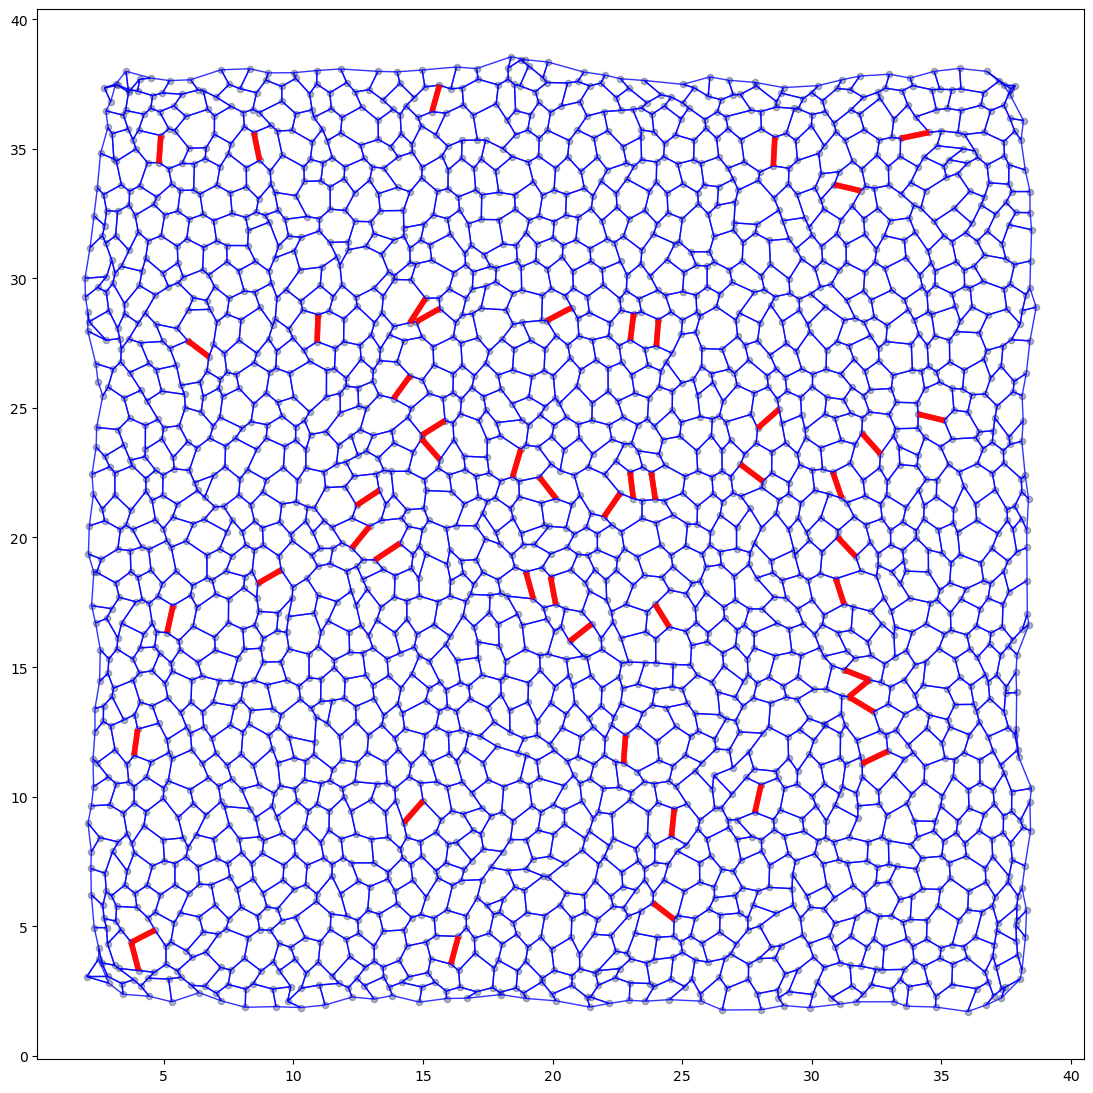

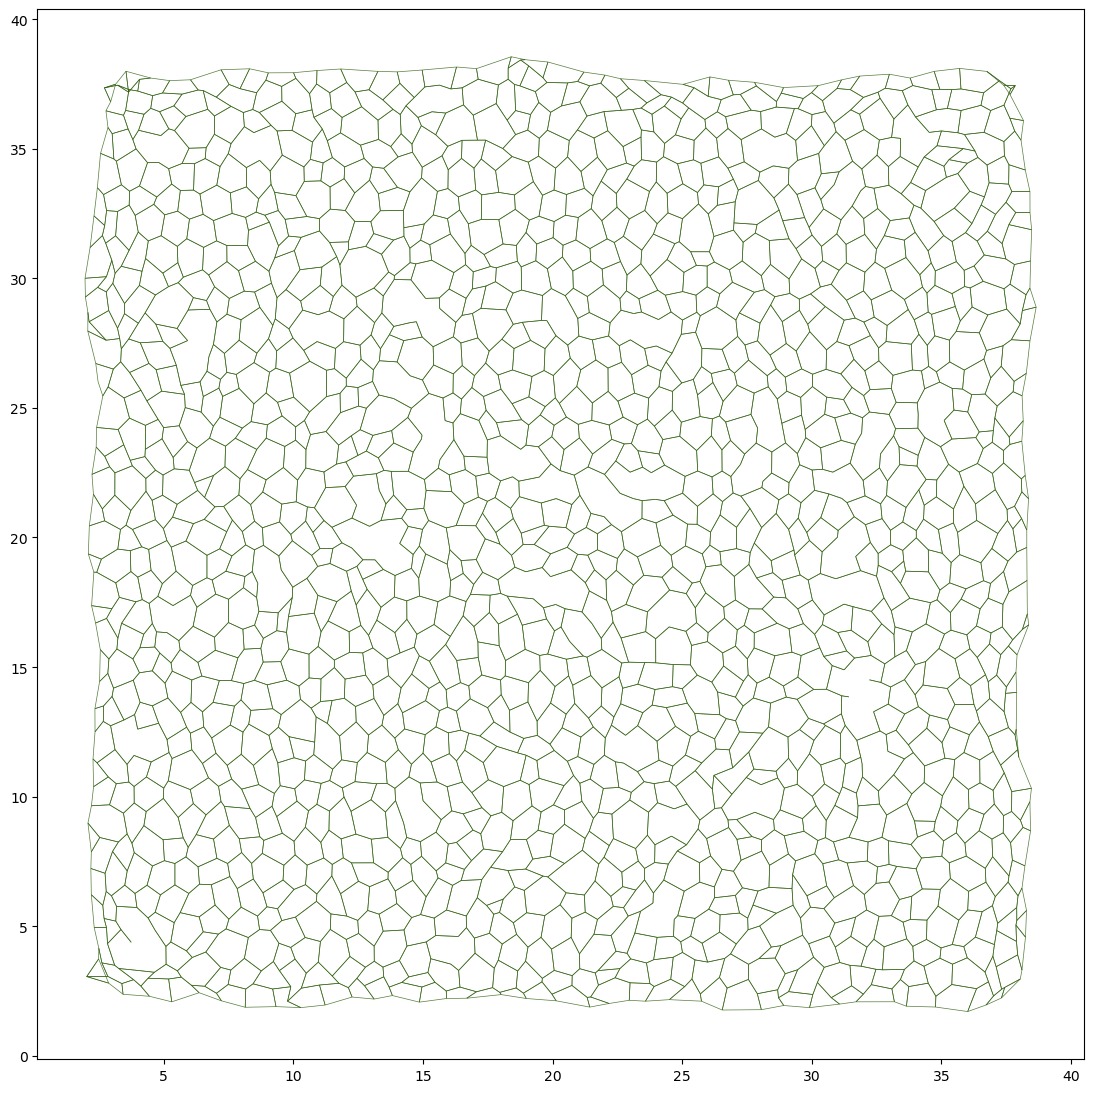

In [113]:
remove_edges_only(cellmap_H,"length", 100)

In [115]:
energyContributions_model.compute_energy(cellmap_H)
vertexModel.solveEuler(cellmap_H, geom, energyContributions_model, 100)


Topology changed!
Topology changed!
Topology changed!


 tyssue.geometry.planar_geometry.PlanarGeometry,
 tyssue.dynamics.factory.model_factory.<locals>.NewModel,

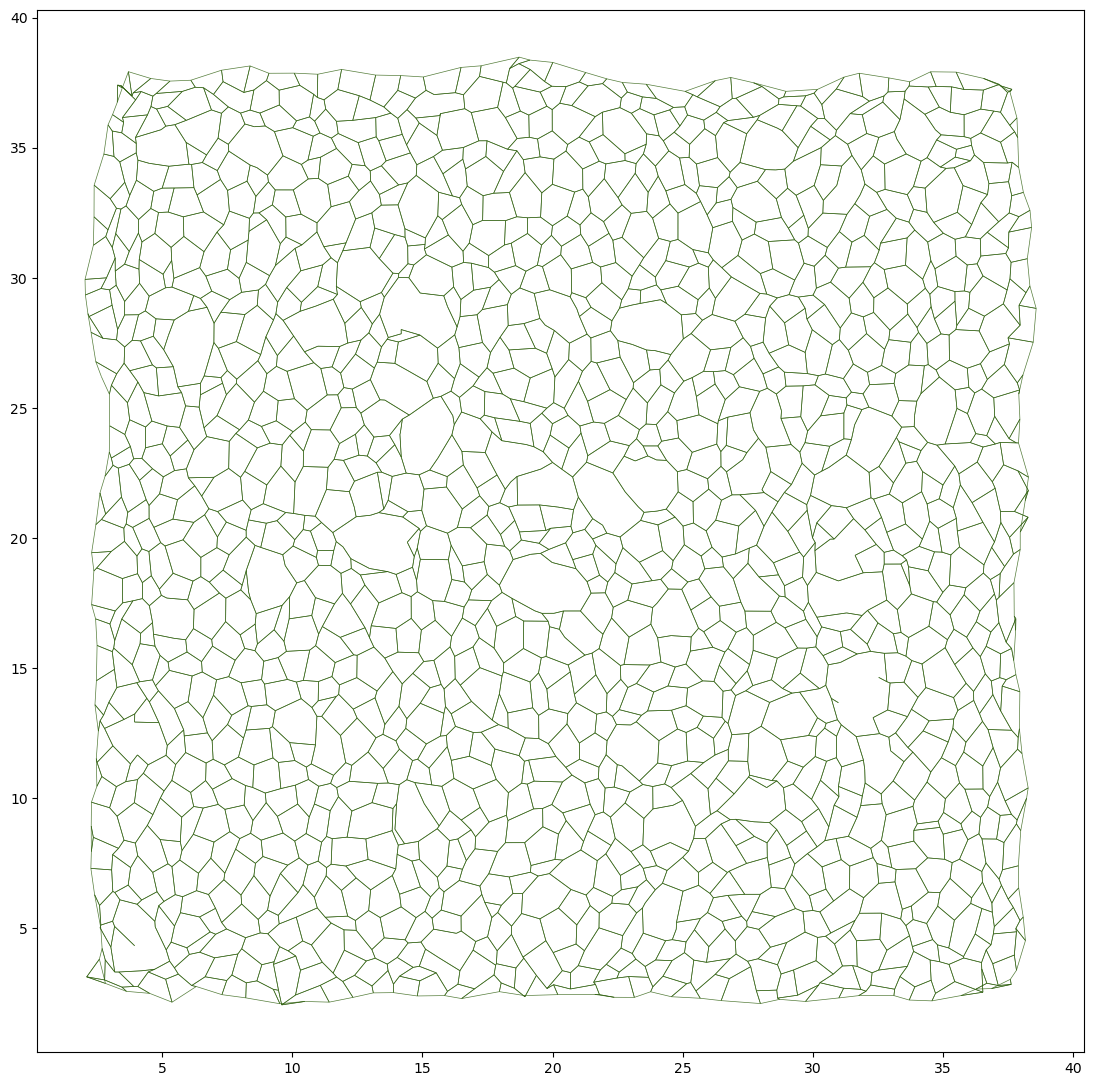

In [116]:
fig, ax = sheet_view(cellmap_H)
fig.set_size_inches((15, 15))


In [ ]:
cellmap_H.edge_df["color_edges"] = 0
cellmap_H.edge_df['edge_width'] = 1

#cellmap_H.edge_df.loc[10, "color_edges"] = 1
#cellmap_H.edge_df.loc[10, 'edge_width'] = 4

specs = {
    'face': {
        'visible': False,
    },
    'edge': {
            'visible': True,
            'color': cellmap_H.edge_df["color_edges"],
            'colormap':'bwr',
            'width' : cellmap_H.edge_df['edge_width'],
    },
    'vert': {
        'visible': True,
        'color' : '#000a4b',
        's' : 20,
    }
}



fig, ax = sheet_view(cellmap_H, **specs)
fig.set_size_inches((15, 15))



In [ ]:
edges_without_opposites_indices, border_edges_indices = cellDivision.edges_list_without_opposites(cellmap_H)

In [ ]:
cellmap_H.edge_df.loc[edges_without_opposites_indices]["length"].nlargest(10).index

In [ ]:
chosen_edges = [3522, 1403, 325, 1209, 4150, 305, 6488, 5286, 4122, 2650, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 , 12, 13]

In [ ]:
cellmap_H.edge_df = cellmap_H.edge_df.drop(chosen_edges)

In [ ]:
cellmap_H.edge_df["color_edges"] = 0
cellmap_H.edge_df['edge_width'] = 1

#cellmap_H.edge_df.loc[10, "color_edges"] = 1
#cellmap_H.edge_df.loc[10, 'edge_width'] = 4

specs = {
    'face': {
        'visible': False,
    },
    'edge': {
            'visible': True,
            'color': cellmap_H.edge_df["color_edges"],
            'colormap':'bwr',
            'width' : cellmap_H.edge_df['edge_width'],
    },
    'vert': {
        'visible': True,
        'color' : '#000a4b',
        's' : 20,
    }
}



fig, ax = sheet_view(cellmap_H, **specs)
fig.set_size_inches((15, 15))

